# ELEKTRA: ELEKTRokardiomatrix Application to biometric identification with Convolutional Neural Networks

This notebook shows an approach of how Elektrokardiomatrix (EKM) are built for ELEKTRA research. All steps from processing the database until obtaining the EKM images are going to be shown.

In [119]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import biosignalsnotebooks as bsnb
import wfdb
from scipy.signal import detrend
import seaborn as sns

#### METHODS AND UTILITIES

These are the main methods used to procvess the EKG and finally construct the EKM. These methods are going to be used along all the project in different steps of the creation of the EKM.

In [120]:
# METHODS AND UTILITITES

# How the EKM is built
def electrocardiomatrix(distance, r_peaks, filtered_ecg, init_window, peaks_window):
    init_seg = int(0.2 * distance)
    fin_seg = int(1.5 * distance)
    all_segments = []
    for peak in r_peaks[init_window:init_window + peaks_window]:
        if peak - init_seg < 0:
            segment = filtered_ecg[0:peak + fin_seg]
        else:
            segment = filtered_ecg[peak - init_seg:peak + fin_seg]
        all_segments.append(segment[:,np.newaxis])
    if all_segments[0].shape[0] < all_segments[1].shape[0]:
        zeros = np.zeros(int(all_segments[1].shape[0])-int(all_segments[0].shape[0]))[:, np.newaxis]
        new_segment = np.concatenate((zeros, all_segments[0]))
        all_segments[0] = new_segment
    try:
      ecm = np.concatenate(all_segments, 1)
    except ValueError:
      return None
    return ecm.T
    
# Normalizing method
def normalize(signal):
    a, b = -1, 1
    c = b - a
    aux = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    norm_ecg = c * aux + a
    return norm_ecg

# Filtering the EKG signal and obtaining its R-peaks with biosignalsnotebook
def process_ecg(unfiltered_ecg, fs):
    # Step 1 of Pan-Tompkins Algorithm - ECG Filtering (Bandpass between 5 and 15 Hz)
    filtered_signal = bsnb.detect._ecg_band_pass_filter(unfiltered_ecg, fs)
    # Step 2 of Pan-Tompkins Algorithm - ECG Differentiation
    differentiated_signal = np.diff(filtered_signal)
    # Step 3 of Pan-Tompkins Algorithm - ECG Rectification
    squared_signal = differentiated_signal * differentiated_signal
    # Step 4 of Pan-Tompkins Algorithm - ECG Integration ( Moving window integration )
    nbr_sampls_int_wind = int(0.080 * fs)
    integrated_signal = np.zeros_like(squared_signal)
    cumulative_sum = squared_signal.cumsum()
    integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] - cumulative_sum[
                                                                                      :-nbr_sampls_int_wind]) / nbr_sampls_int_wind
    integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / np.arange(1, nbr_sampls_int_wind + 1)
    # Initialisation of the R peak detection algorithm
    rr_buffer, signal_peak_1, noise_peak_1, threshold = bsnb.detect._buffer_ini(integrated_signal, fs)
    # Detection of possible and probable R peaks
    probable_peaks, possible_peaks = bsnb.detect._detects_peaks(integrated_signal, fs)
    # Identification of definitive R peaks
    definitive_peaks = bsnb.detect._checkup(probable_peaks, integrated_signal, fs, rr_buffer, signal_peak_1,
                                            noise_peak_1, threshold)
    # Conversion to integer type.
    definitive_peaks = np.array(list(map(int, definitive_peaks)))
    # Correcting step
    map_integers = definitive_peaks - 40 * (fs / 1000)
    definitive_peaks_reph = np.array(list(map(int, map_integers)))
    return definitive_peaks_reph, filtered_signal

# Calculates the mean distance between all peaks for each user
def peak_distance(r_peaks):
    dist = []
    for i in range(len(r_peaks)):
        if r_peaks[i] == r_peaks[-1]:
            break
        distance = r_peaks[i + 1] - r_peaks[i]
        if i == 0:
            dist.append(distance)
            continue
        if distance > np.mean(dist) + np.std(dist) * 2:
            continue
        else:
            dist.append(distance)
    return np.mean(dist)

def save_ecm(norm_ecm, train_filled, test_filled, train_ecms, test_ecms, path_test, path_train, key, i, f, j):
    a = np.random.uniform(0, 1)
    if a <= 0.2 or train_filled:
        plt.savefig(path_test + '\\' + '5bpf-ekm-test-' + key + '-' + str(i))
        j += 1
        if j > test_ecms:
            test_filled = True

    elif a > 0.2 or test_filled:
        plt.savefig(path_train + '\\' +'5bpf-ekm-train-' + key + '-' + str(i))
        f += 1
        if f >= train_ecms:
            train_filled = True
    plt.close()
    plt.close('all')
    return j,f 

## FIRST PHASE: Obtain the filtered signal and its peaks

In this first phase of the code we process the database to obtain the filtered ECG and a list of its peaks for each user. As we are only showing an approach, only one user from the (MIT-BIH Normal Sinus Rhythm Database (NSRDB))[https://physionet.org/content/nsrdb/1.0.0/] will be processed. The signal is filtered with the Pan and Tompkins algorithm from the (Biosignalsnotebook Library)[https://pypi.org/project/biosignalsnotebooks/] for python.

In [121]:
fs = 128
dat_file = '16795\\16795.dat'
ddbb_record = dat_file.replace(".dat", "")
sig, fields = wfdb.rdsamp(ddbb_record)
unfiltered_ecg = sig[:, 0]
peaks, filtered_ecg = process_ecg(unfiltered_ecg, fs)

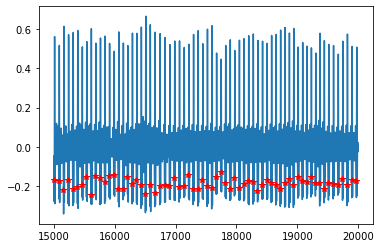

96814

In [122]:
# Code to show an ECG signal with its peaks from a to b
a = 15000
b = 20000
peaks_show = [x for x in peaks if (x>=a and x<=b)]
plt.figure()
plt.plot(range(a,b), filtered_ecg[a:b])
plt.plot(peaks_show, filtered_ecg[peaks_show], 'r*')
plt.show()

len(peaks)

## SECOND PHASE: Obtaining the EKM

In [123]:
# Number of peaks to be taken (from 0 to 6)
key = '16795'
train_path = 'EKM\\16795\\Train'
test_path = 'EKM\\16795\\Test'
bpf = 5
peaks_window = bpf-1
data_obtained = []
distances = []
negative = True
j, f, i, init_window = 0, 0, 0, 0
total_ecms = 20
test_ecms = int(0.2 * total_ecms)
train_ecms = int(0.8 * total_ecms)
train_filled, test_filled = False, False

In [124]:
detrend_signal = detrend(filtered_ecg)
print('DETREND applied')
norm_ecg = normalize(detrend_signal)
print('NORMALIZATION applied')
# The distance calculation, may take a while
distance = peak_distance(peaks)
print('Distance calculated')

while((j+f)<total_ecms):
    if (init_window >= len(peaks)) or (init_window >= len(peaks)-1): break
    ecm = electrocardiomatrix(distance, peaks, norm_ecg, init_window, peaks_window)
    if ecm is None: break
    distance = int(distance)
    norm_ecm = normalize(ecm)
    sns.heatmap(norm_ecm, xticklabels=False, yticklabels=False)
    j, f = save_ecm(norm_ecm, train_filled, test_filled, train_ecms, test_ecms, test_path, train_path, key, i, f, j)
    init_window += bpf
    i += 1

DETREND applied
NORMALIZATION applied
Distance calculated
